In [1]:
%cd ..

/home/ubuntu/dev/edge/py-edge-eval


# Plot PR Curves (Cityscapes)

In [2]:
import os.path as osp

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from scipy.interpolate import interp1d

In [4]:
from IPython.display import display

In [5]:
%matplotlib inline
# %matplotlib widget

In [6]:
%%capture
fig, ax = plt.subplots()

In [7]:
def _isometric_contour_line_template(
    ax=None,
):
    """Setup Basic Isometric Contour Line Plot"""
    if ax is None:
        ax = plt.gca()

    # plt.box(True)
    ax.set_frame_on(True)
    ax.grid(True)
    ax.axhline(0.5, 0, 1, linewidth=2, color=[0.7, 0.7, 0.7])
    for f in np.arange(0.1, 1, 0.1):
        r = np.arange(f, 1.01, 0.01)
        p = f * r / (2 * r - f)
        ax.plot(r, p, color=[0, 1, 0])
        ax.plot(p, r, color=[0, 1, 0])

    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_yticks(np.linspace(0, 1, 11))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_aspect("equal", adjustable="box")
    ax.set(xlim=(0, 1), ylim=(0, 1))

    return ax

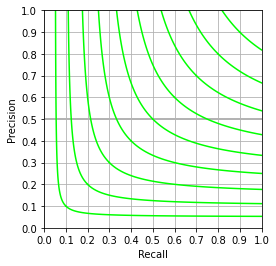

In [8]:
ax = _isometric_contour_line_template(ax=ax)
display(fig)

In [9]:
def _calc_r50(pr):
    _, o = np.unique(pr[:, 2], return_index=True)
    r50 = interp1d(
        pr[o, 2],
        pr[o, 1],
        bounds_error=False,
        fill_value=np.nan,
    )(np.maximum(pr[o[0], 2], 0.5))

    return r50

def _load_threshold_data(data_path):
    assert osp.exists(data_path), f"ERR: {data_path} doesn't exist"
    pr = np.loadtxt(data_path)
    pr = pr[pr[:, 1] >= 1e-3]
    return pr

def _load_overall_results(data_path):
    assert osp.exists(data_path), f"ERR: {data_path} doesn't exist"
    res = np.loadtxt(data_path)
    return res[:8]

In [10]:
from collections import namedtuple

AlgorithmInfo = namedtuple(
    "AlgorithmInfo",
    [
        "name",  # name
        "threshold_results",  # path
        "overall_results",  # path
    ],
)

In [11]:
# initialize data
category = 1

names = ['MATLAB', 'Python']
thr_paths = [
    osp.join('data', 'dff_matlab_results', 'dff', f'class_{str(category).zfill(3)}', 'eval_bdry_thr.txt'),
    osp.join('scripts', 'results', 'cityscapes_dff_r101', f'class_{str(category).zfill(3)}', 'eval_bdry_thr.txt'),
]
res_paths = [
    osp.join('data', 'dff_matlab_results', 'dff', f'class_{str(category).zfill(3)}', 'eval_bdry.txt'),
    osp.join('scripts', 'results', 'cityscapes_dff_r101', f'class_{str(category).zfill(3)}', 'eval_bdry.txt'),
]

algs = []
for n, t, r in zip(names, thr_paths, res_paths):
    assert osp.exists(t)
    assert osp.exists(r)
    algs.append(AlgorithmInfo(n, t, r))

In [12]:
# main logic for plots

n = len(algs)

names = [a.name for a in algs]
names = np.array(names)

colors = cm.rainbow(np.linspace(0, 1, n))
colors = np.array(colors)

hs, res, prs = [None] * n, np.zeros((n, 9), dtype=np.float32), []
for i, alg in enumerate(algs):
    pr = _load_threshold_data(alg.threshold_results)
    res[i, :8] = _load_overall_results(alg.overall_results)
    res[i, 8] = _calc_r50(pr)
    prs.append(pr)
prs = np.stack(prs, axis=0)

# sort algorithms by ODS score
o = np.argsort(res[:, 3])[::-1]
res, prs, names, colors = res[o, :], prs[o], names[o], colors[o]

In [13]:
# plot results for every algorithm (plot best last)
for i in range(n - 1, -1, -1):
    hs[i] = ax.plot(
        prs[i, :, 1],
        prs[i, :, 2],
        linestyle="-",
        linewidth=3,
        color=colors[i],
    )[0]
    prefix = "ODS={:.3f}, OIS={:.3f}, AP={:.3f}, R50={:.3f}".format(
        *res[i, [3, 6, 7, 8]]
    )
    prefix += " - {}".format(names[i])
    print(prefix)

# add legends
legend_texts = [
    "[F={:.2f}] {}".format(res[i, 3], names[i]) for i in range(n)
]
ax.legend(hs, legend_texts, loc="lower left")

ODS=0.935, OIS=0.939, AP=0.876, R50=0.988 - Python
ODS=0.936, OIS=0.940, AP=0.635, R50=0.992 - MATLAB


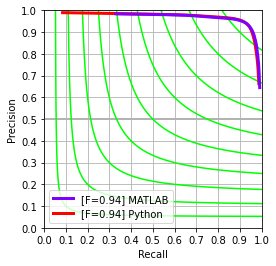

In [14]:
display(fig)